Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.image as image
import warnings
warnings.filterwarnings('ignore')

In [2]:
# If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
#p = pathlib.Path('gdrive/MyDrive/CNN_Data/Train')
#for x in p.iterdir():
#  print(x)
#print(list(p.glob('*/*.jpg'))[0])

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
# data_dir_train = pathlib.Path("gdrive/MyDrive/CNN_Data/Train")
# data_dir_test = pathlib.Path("gdrive/MyDrive/CNN_Data/Test")

data_dir_train = pathlib.Path(r"C:\Users\Rebel\Documents\upgrad\CNN_assignment\CNN_Data\Train")
data_dir_test = pathlib.Path(r"C:\Users\Rebel\Documents\upgrad\CNN_assignment\CNN_Data\Test")


In [5]:
#counting images in train and test folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
# train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
#     data_dir_train, labels='inferred', label_mode='categorical', 
#     color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),  seed=123
# )

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2, # here we splitting the data. 0.2 means 20% of validation set
  subset="training", #the subset return of this function
  seed=123,
  image_size=(img_height, img_width), #resizing will be done here while reading the image
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
# make sure your resize your images to the size img_height*img_width, while writting the dataset
# for i in list(data_dir_test.glob('*/*.jpg')):
#   im=PIL.Image.open(i)
#   im.resize((img_height,img_width))



In [10]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     data_dir_test, labels='inferred', label_mode='categorical', 
#     color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),  seed=123
# )
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

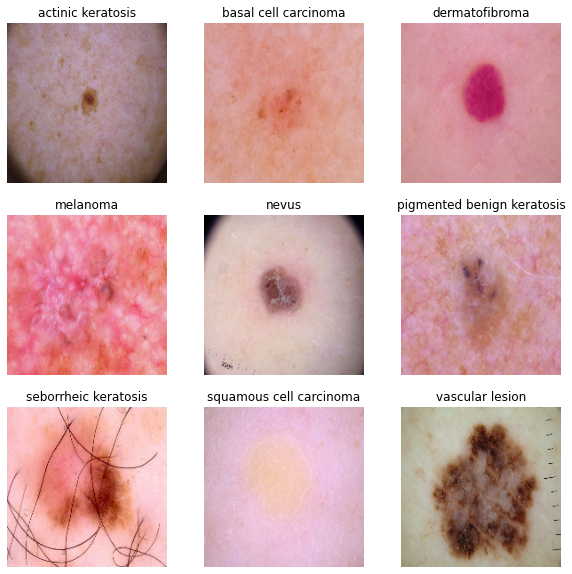

In [13]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use `layers.experimental.preprocessing.Rescaling` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
# normalising = layers.experimental.preprocessing.Rescaling(1/255, 0.0)

# normalized_ds = train_ds.map(lambda x, y: (normalising(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # rescaling of images is done here
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 21s 318ms/step - loss: 2.0743 - accuracy: 0.1987 - val_loss: 2.0307 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 17s 305ms/step - loss: 1.9937 - accuracy: 0.2388 - val_loss: 1.7768 - val_accuracy: 0.3848
Epoch 3/20
56/56 [==============================] - 17s 313ms/step - loss: 1.7497 - accuracy: 0.3795 - val_loss: 1.5101 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 18s 319ms/step - loss: 1.4669 - accuracy: 0.4989 - val_loss: 1.5199 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 18s 319ms/step - loss: 1.3515 - accuracy: 0.5329 - val_loss: 1.3691 - val_accuracy: 0.5503
Epoch 6/20
56/56 [==============================] - 18s 331ms/step - loss: 1.3170 - accuracy: 0.5363 - val_loss: 1.4131 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 20s 355ms/step - loss: 1.2057 - accuracy: 0.5753 - val_loss: 1.3951 - val_accuracy: 0.5324

### Visualizing training results

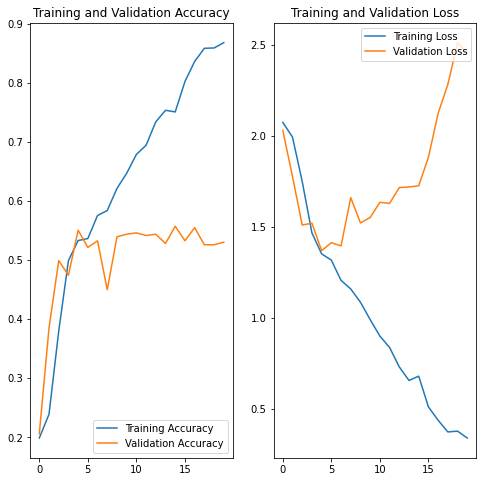

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The training accuracy is increasing after each epoch. Validation accuracy also increased initially but got saturated after some epochs.
#### Finally training accuracy is too high and validation accuracy is low , and the model has achieved  around 53.02% accuracy on the validation set.
#### Our model is overfitting.

#### Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

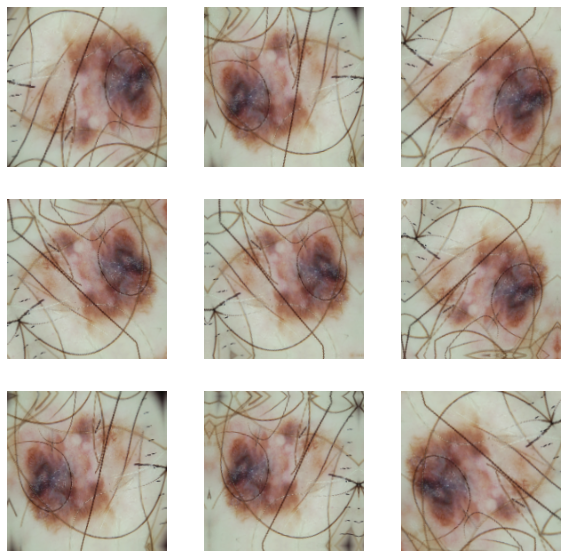

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Another technique to reduce overfitting is to introduce dropout regularization to the network.

#### When we apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [23]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compiling the model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 26s 436ms/step - loss: 2.0244 - accuracy: 0.2444 - val_loss: 1.9087 - val_accuracy: 0.3087
Epoch 2/20
56/56 [==============================] - 24s 433ms/step - loss: 1.6714 - accuracy: 0.4068 - val_loss: 1.6357 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 24s 427ms/step - loss: 1.5089 - accuracy: 0.4710 - val_loss: 1.4375 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 23s 419ms/step - loss: 1.4633 - accuracy: 0.4888 - val_loss: 1.5378 - val_accuracy: 0.4586
Epoch 5/20
56/56 [==============================] - 25s 440ms/step - loss: 1.3653 - accuracy: 0.5357 - val_loss: 1.4446 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 24s 422ms/step - loss: 1.3537 - accuracy: 0.5179 - val_loss: 1.4765 - val_accuracy: 0.4720
Epoch 7/20
56/56 [==============================] - 23s 415ms/step - loss: 1.3260 - accuracy: 0.5262 - val_loss: 1.5070 - val_accuracy: 0.5078

### Visualizing the results

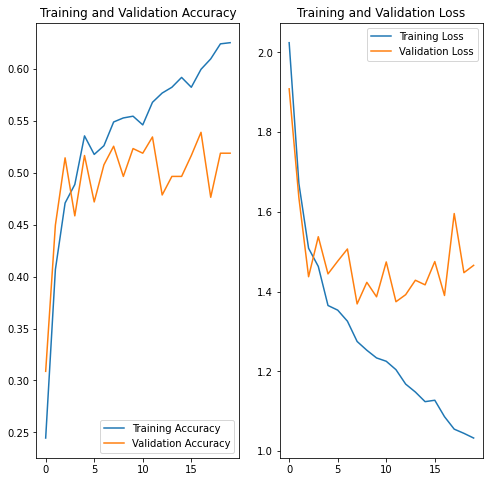

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Training accuracy has been decreased and little change in validation accuracy. The drop from train accuracy to validation accuracy is less. Lets see if there is still improvement we can do in model.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [29]:
class_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [30]:
dataframe_dict = dict(zip(path_list, class_list))

In [31]:
df1 = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
df1['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### - Which class has the least number of samples?
#### seborrheic keratosis category cancer has least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
#### pigmented benign keratosis and melanoma dominate in terms of proportionate of number of samples


#### The data is highly imbalance. We can see that 50% of classes have more that 10% of data and rest 50% classess have less than 10% of data.

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor


[notice] A new release of pip available: 22.2.1 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset="C:/Users/Rebel/Documents/upgrad/CNN_assignment/CNN_Data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:/Users/Rebel/Documents/upgrad/CNN_assignment/CNN_Data/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21107761D50>: 100%|█| 500/500 [00:03<00:00, 162.71 Samples


Initialised with 376 image(s) found.
Output directory set to C:/Users/Rebel/Documents/upgrad/CNN_assignment/CNN_Data/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21104BFFF10>: 100%|█| 500/500 [00:03<00:00, 156.00 Samples


Initialised with 95 image(s) found.
Output directory set to C:/Users/Rebel/Documents/upgrad/CNN_assignment/CNN_Data/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2110774D330>: 100%|█| 500/500 [00:03<00:00, 158.71 Samples


Initialised with 438 image(s) found.
Output directory set to C:/Users/Rebel/Documents/upgrad/CNN_assignment/CNN_Data/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=965x649 at 0x2110779F850>: 100%|█| 500/500 [00:19<00:00, 25.61 Samples/


Initialised with 357 image(s) found.
Output directory set to C:/Users/Rebel/Documents/upgrad/CNN_assignment/CNN_Data/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2113BE63A00>: 100%|█| 500/500 [00:16<00:00, 30.59 Samples/


Initialised with 462 image(s) found.
Output directory set to C:/Users/Rebel/Documents/upgrad/CNN_assignment/CNN_Data/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21100EA0940>: 100%|█| 500/500 [00:02<00:00, 167.52 Samples


Initialised with 77 image(s) found.
Output directory set to C:/Users/Rebel/Documents/upgrad/CNN_assignment/CNN_Data/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x21100DD6680>: 100%|█| 500/500 [00:07<00:00, 64.47 Samples


Initialised with 181 image(s) found.
Output directory set to C:/Users/Rebel/Documents/upgrad/CNN_assignment/CNN_Data/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21104CD9960>: 100%|█| 500/500 [00:03<00:00, 145.68 Samples


Initialised with 139 image(s) found.
Output directory set to C:/Users/Rebel/Documents/upgrad/CNN_assignment/CNN_Data/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21100DD74C0>: 100%|█| 500/500 [00:03<00:00, 143.67 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [37]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df1.append(df2)

In [39]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [41]:
data_dir_train=pathlib.Path(r"C:\Users\Rebel\Documents\upgrad\CNN_assignment\CNN_Data\Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Create your model (make sure to include normalization)

In [43]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

####  Compile your model (Choose optimizer and loss function appropriately)

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               loss='categorical_crossentropy',
              metrics=['accuracy'])

####   Train your model

In [45]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 70s 412ms/step - loss: 1.8739 - accuracy: 0.2893 - val_loss: 1.5294 - val_accuracy: 0.4358
Epoch 2/30
169/169 [==============================] - 68s 399ms/step - loss: 1.4218 - accuracy: 0.4594 - val_loss: 1.3940 - val_accuracy: 0.4981
Epoch 3/30
169/169 [==============================] - 73s 431ms/step - loss: 1.1657 - accuracy: 0.5608 - val_loss: 1.2245 - val_accuracy: 0.5664
Epoch 4/30
169/169 [==============================] - 73s 430ms/step - loss: 1.0182 - accuracy: 0.6322 - val_loss: 0.9914 - val_accuracy: 0.6488
Epoch 5/30
169/169 [==============================] - 73s 432ms/step - loss: 0.7851 - accuracy: 0.7125 - val_loss: 1.1450 - val_accuracy: 0.6006
Epoch 6/30
169/169 [==============================] - 72s 423ms/step - loss: 0.6220 - accuracy: 0.7728 - val_loss: 0.8235 - val_accuracy: 0.7164
Epoch 7/30
169/169 [==============================] - 73s 431ms/step - loss: 0.4950 - accuracy: 0.8144 - val_loss: 0.7629 - val_ac

#### Visualize the model results

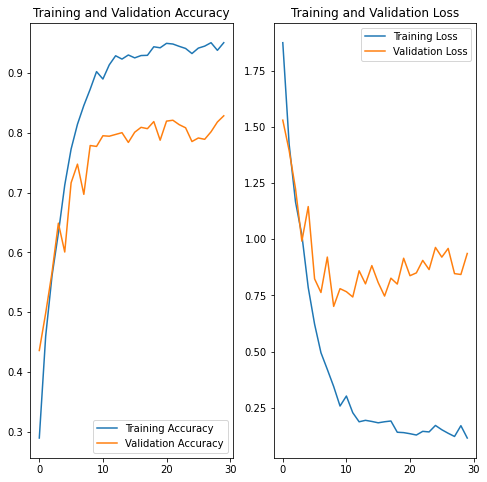

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Overfitting is handled to some extent. Class rebalance helped in improving the accuracy of train set and  Now my model has acheived 82.85% of validation accuracy.